In [1]:
# Author : Trong Canh Nguyen

# This script considers all the products a user has ordered
#
# We train a model computing the probability of reorder on the "train" data
#
# For the submission, we keep the orders that have a probability of
# reorder higher than a threshold


import numpy as np
import pandas as pd
import lightgbm as lgb
import gc
IDIR = '../input/'

FEATURES_PATH = './features3/'

In [9]:
gc.collect()

24

## Data Load

In [ ]:
import pickle
with open(FEATURES_PATH + 'dtypes.pickle', 'rb') as f:
    dtype_dict = pickle.load(f)
dtype_dict

In [ ]:
#data = pd.read_csv(FEATURES_PATH + "data.csv", dtype= dtype_dict)

In [2]:
data = pd.read_hdf(FEATURES_PATH + "data.h5", "data")
data.reset_index(inplace=True)
print("memory = ", data.memory_usage().sum()/1000000)

memory =  1211.023803


In [26]:
data.head()

up_orders  up_first_order  up_last_order  up_order_rate  \
user_id product_id                                                            
1       196                10               1             10            1.0   
        10258               9               2             10            0.9   
        10326               1               5              5            0.1   
        12427              10               1             10            1.0   
        13032               3               2             10            0.3   

                    up_orders_since_last_order  \
user_id product_id                               
1       196                                0.0   
        10258                              0.0   
        10326                              5.0   
        12427                              0.0   
        13032                              0.0   

                    up_order_rate_since_first_order  up_days_since_last_order  \
user_id product_id                                                              
1       196                                1.000000                        14   
        10258                              1.000000                        14   
        10326                              0.166667                        97   
        12427                              1.000000                        14   
        13032                              0.333333                        14   

                    up_add_to_cart_order_mean  user_total_order user_eval_set  \
user_id product_id                                                              
1       196                          1.400000                10         train   
        10258                        3.333333                10         train   
        10326                        5.000000                10         train   
        12427                        3.300000                10         train   
        13032                        6.333333                10         train   

                            ...            user_order_size_mean  \
user_id product_id          ...                                   
1       196                 ...                             5.9   
        10258               ...                             5.9   
        10326               ...                             5.9   
        12427               ...                             5.9   
        13032               ...                             5.9   

                    product_reorder_ratio  aisle_id  department_id  \
user_id product_id                                                   
1       196                      0.776480        77              7   
        10258                    0.713772       117             19   
        10326                    0.652009        24              4   
        12427                    0.740735        23             19   
        13032                    0.657158       121             14   

                    up_in_same_day_previous_order  up_reordered  \
user_id product_id                                                
1       196                                     0           1.0   
        10258                                   0           1.0   
        10326                                   0           0.0   
        12427                                   0           0.0   
        13032                                   0           1.0   

                    aisle_reorder_rate  dep_reorder_rate  \
user_id product_id                                         
1       196                   0.685758          0.696882   
        10258                 0.552527          0.612557   
        10326                 0.763352          0.692611   
        12427                 0.633501          0.612557   
        13032                 0.613882          0.600948   

                    user_aisle_reorder_rate  user_dep_reorder_rate  
user_id product_id                                        

# MODEL

In [6]:
features = [    
    'up_orders',
    'up_add_to_cart_order_mean',
    'up_order_rate',
    'up_order_rate_since_first_order',
    'up_orders_since_last_order',
    'up_days_since_last_order',
    'up_in_same_day_previous_order',
    
    'user_total_order',
    'user_order_size_mean',
    'user_reorder_rate',
    'user_days_since_last_order',   
    
    'product_reorder_ratio',
    
    'aisle_reorder_rate',
    'user_aisle_reorder_rate',
    
    'dep_reorder_rate',
    'user_dep_reorder_rate'
]

        
data_train = data[data.user_eval_set == "train"][['user_id', 'product_id']+ features + ["up_reordered"]]

In [ ]:
tmp = data_train.user_id.unique()
user_train = tmp[0:120000]
user_test = tmp[120000:]

X_train= data_train[data_train.user_id.isin(user_train)][features]
y_train= data_train[data_train.user_id.isin(user_train)]['up_reordered']
X_valid= data_train[data_train.user_id.isin(user_test)][features]
y_valid= data_train[data_train.user_id.isin(user_test)]['up_reordered']

In [ ]:
print('formating for lgb')
d_train = lgb.Dataset(X_train, label=y_train)
d_valid = lgb.Dataset(X_valid, label=y_valid, reference=d_train)
d_train.save_binary(FEATURES_PATH +  'train.bin')
d_valid.save_binary(FEATURES_PATH +  'valid.bin')

In [ ]:
del data_train
del X_train
del y_train
del X_valid
del y_valid
gc.collect()

In [ ]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss'},
    'num_leaves': 200,
    'max_depth': 10,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.95,
    'bagging_freq': 5
}
ROUNDS = 100

print('light GBM train :-)')
bst = lgb.train(params, d_train, ROUNDS)

In [ ]:
bst.save_model(FEATURES_PATH+ 'trained_model.txt')

In [ ]:
bst.add_valid(d_valid, "valid1")

In [ ]:
bst.eval_train()

In [ ]:
bst.eval_valid()

### Validation

In [ ]:
def precision(y, y_, correct):
    if y_>0:
        return correct/y_
    else:
        return 1.0
        
def recall(y, y_, correct):
    if y>0:
        return correct/y
    else:
        return 1.0

def f1(y,y_, correct):
    p = precision(y, y_, correct)
    r = recall(y, y_, correct)
    if (p == 0) and (r ==0):
        return 0.
    f1 = 2*p*r/(p+r)
    return f1

def compute_f1(valid_df, threshold):
    valid_df['y_'] = valid_df['pred'] > threshold
    valid_df['correct'] = (valid_df['y'] == valid_df['y_']) & (valid_df['y_'])
    result = valid_df.groupby('user_id').sum()
    result['f1'] = result.apply(lambda row: f1(row['y'], row['y_'], row['correct']), axis=1)
    return result['f1'].mean()

In [ ]:
pred_valid = bst.predict(X_valid)

In [ ]:
valid_df = data.ix[X_valid.index][['user_id', 'product_id']]
valid_df["y"] = y_valid
valid_df["pred"] = pred_valid
valid_df["y_"] = valid_df["pred"]  >= 0.20
valid_df['correct'] = (valid_df['y'] == valid_df['y_']) & (valid_df['y_'])
valid_df.sort_values(['user_id', 'pred'], ascending=[True, False], inplace = True)
#print("valid log loss = ", -((valid_df["y"]*np.log(valid_df["pred"])+ (1.-valid_df["y"])* np.log(1.- valid_df["pred"]))).mean())

In [ ]:
result = valid_df.groupby('user_id').sum()
result['f1'] = result.apply(lambda row: f1(row['y'], row['y_'], row['correct']), axis=1)

In [ ]:
result[result.y_ == 0]

In [ ]:
compute_f1(valid_df, 0.20)

## Generate predictions

In [7]:
data_test = data[data.user_eval_set == "test"][['user_id', 'product_id'] + features]

In [8]:
bst = lgb.Booster(model_file=FEATURES_PATH+ 'trained_model.txt')

In [10]:
print('light GBM predict')
pred_test = bst.predict(data_test[features])
pred_test

light GBM predict


array([ 0.02037025,  0.06086408,  0.11589927, ...,  0.00556573,
        0.00359589,  0.01072436])

In [11]:
orders = pd.read_csv(IDIR + 'orders.csv', dtype={
        'order_id': np.int32,
        'user_id': np.int32},
        usecols=["order_id", "user_id", "eval_set"])

test_orders= orders[orders.eval_set == 'test']

In [12]:
prediction = pd.DataFrame()
prediction[['user_id', 'product_id']] = data_test[['user_id', 'product_id']]
prediction['proba'] = pred_test
prediction.sort_values(by=['user_id', 'proba'], ascending=[True, False], inplace=True)
prediction = pd.merge(prediction, test_orders[['order_id', 'user_id']], on="user_id", how='left')

## Feature importance

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

Plot feature importances...


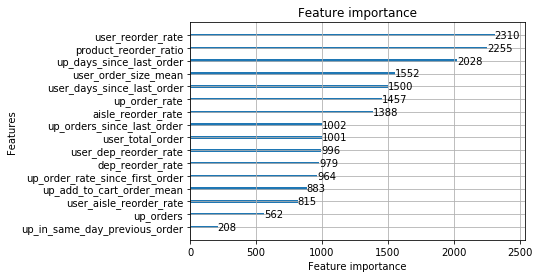

In [15]:
print('Plot feature importances...')
ax = lgb.plot_importance(bst, max_num_features=20)
plt.show()


### Recommendation using threshold

In [16]:
threshold = 0.20
recommend = prediction[prediction.proba >= threshold].groupby('order_id').product_id.apply(list)

In [17]:
recommend_df = pd.DataFrame()
recommend_df["count"] = prediction.groupby('order_id').size()
recommend_df['product_list'] = recommend
recommend_df['products']= recommend_df.product_list.apply(lambda p: ' '.join([str(x)  for x in p]) if type(p) == list else 'None' ) 

In [18]:
recommend_df.head()

,count,product_list,products
order_id,,,
17,21,"[13107, 21463, 38777, 21709]",13107 21463 38777 21709
34,78,"[16083, 47766, 39475, 21137, 43504, 2596, 4779...",16083 47766 39475 21137 43504 2596 47792 13176...
137,68,"[24852, 38689, 23794, 41787, 25890, 2326, 5134]",24852 38689 23794 41787 25890 2326 5134
182,100,"[9337, 39275, 5479, 47672, 13629, 41149, 11520...",9337 39275 5479 47672 13629 41149 11520 47209 ...
257,57,"[24852, 49235, 27104, 37646, 27966, 29837, 394...",24852 49235 27104 37646 27966 29837 39475 3023...


In [19]:
recommend_df['products'].to_csv(FEATURES_PATH + 'recommend2.csv', header = True)

### Recommendation using average user basket

In [ ]:
products = []
count = 0
for _,row in test_orders[['user_id', 'order_id']].iterrows():
    count += 1
    if (count)%10000 == 0:
        print(count)    
    
    user_id, order_id = row['user_id'], row['order_id']
    n = int(user_basket_avg.ix[user_id].basket_size_avg)+1
    products.append(list(prediction[prediction.user_id == user_id].product_id[:n]))
    
# create submission
submission = pd.DataFrame()
submission['order_id'] = test_orders['order_id']
submission['products'] = [' '.join([str(x) for x in p]) for p in products]
submission.sort_values(by='order_id', inplace = True)
submission.to_csv(FEATURES_PATH + 'submission.csv', index=False)